# Imports

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

sys.path.insert(0, os.path.abspath(os.path.join("..", "src")))
from modeling import load_features, test_models, print_performance, hyperparameters_tuning, add_model_to_pipeline
from exploration import read_and_split

# Preliminary modeling

We will test various models on our data in order to narrow it down to a few of the best ones, which we will later fine-tune. First we will load our preprocessed features. Implementation of load_features can be found in src/modeling.py. 

In [2]:
features = ['train_bow', 'train_tfidf', 'valid_bow', 'valid_tfidf']
features_paths = [f'../data/processed/features_{feat}.pkl' for feat in features]

features_train_bow, features_train_tfidf, features_valid_bow, features_valid_tfidf = load_features(features_paths)
_, y_train, _, y_valid, _, _ = read_and_split('../data/raw/tweets.csv')

## BOW features

Fitting LinearSVC...
Fitting time: 321.73975443840027
Prediction time: 0.02369213104248047
Fitting LogisticRegression...
Fitting time: 69.83837890625
Prediction time: 0.021891117095947266
Fitting MultinomialNB...
Fitting time: 0.4568936824798584
Prediction time: 0.07090020179748535
Fitting ComplementNB...
Fitting time: 0.48226141929626465
Prediction time: 0.06865525245666504
Fitting XGBClassifier...
Fitting time: 345.2060031890869
Prediction time: 155.5574414730072


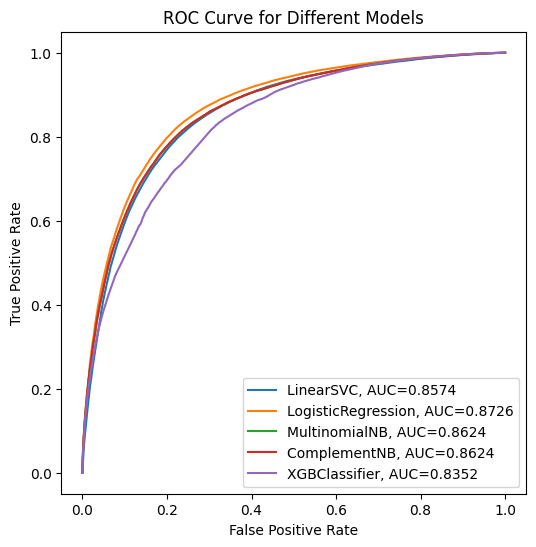

In [3]:
models = [LinearSVC(), LogisticRegression(), MultinomialNB(), ComplementNB(), XGBClassifier()]
performance = test_models(models, features_train_bow, y_train, features_valid_bow, y_valid)

In [4]:
print_performance(performance)

================LinearSVC================
Accuracy: 0.7861
F1_score: 0.7886
================LogisticRegression================
Accuracy: 0.7992
F1_score: 0.8016
================MultinomialNB================
Accuracy: 0.7886
F1_score: 0.786
================ComplementNB================
Accuracy: 0.7886
F1_score: 0.786
================XGBClassifier================
Accuracy: 0.756
F1_score: 0.7702


## TF-IDF features

Fitting LinearSVC...
Fitting time: 20.29624366760254
Prediction time: 0.018583059310913086
Fitting LogisticRegression...
Fitting time: 82.86176705360413
Prediction time: 0.022304534912109375
Fitting MultinomialNB...
Fitting time: 0.3513460159301758
Prediction time: 0.06454038619995117
Fitting ComplementNB...
Fitting time: 0.4169154167175293
Prediction time: 0.06774735450744629
Fitting XGBClassifier...
Fitting time: 629.8445136547089
Prediction time: 155.9607789516449


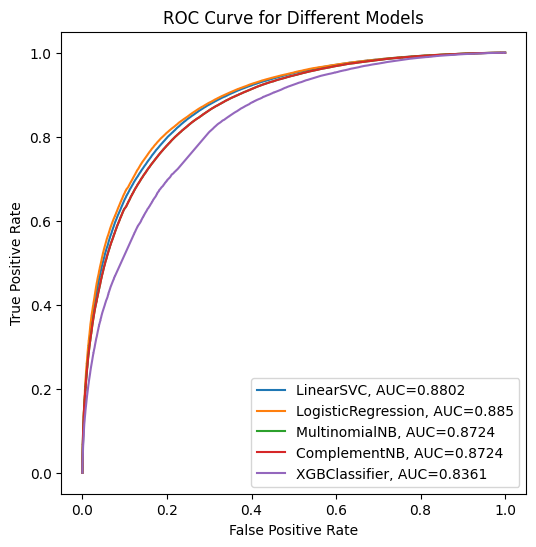

In [5]:
models = [LinearSVC(), LogisticRegression(), MultinomialNB(), ComplementNB(), XGBClassifier()]
performance = test_models(models, features_train_tfidf, y_train, features_valid_tfidf, y_valid)

In [6]:
print_performance(performance)

================LinearSVC================
Accuracy: 0.7989
F1_score: 0.7998
================LogisticRegression================
Accuracy: 0.8047
F1_score: 0.8062
================MultinomialNB================
Accuracy: 0.7892
F1_score: 0.7854
================ComplementNB================
Accuracy: 0.7892
F1_score: 0.7854
================XGBClassifier================
Accuracy: 0.7556
F1_score: 0.7687


From the tests above, we can see that using TF-IDF features yields better results. While LinearSVC and LogisticRegression perform the best, Naive Bayes approaches require much less computation and achieve only slightly worse results. We will tune hyperparameters for LinearSVC, LogisticRegression and MultinomialNB.

# Tuning Hyperparameters

We will use RandomizedSearchCV first to determine a promising area in the hyperparameter space. Then, we will perform GridSearchCV for a more thorough search.

## LinearSVC

### RandomSearch

In [5]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1],
}

model = LinearSVC()
search_result = hyperparameters_tuning(param_grid, model, folds=5, param_comb=10, X=features_train_tfidf, y=y_train, use_random_search=True)

Best Hyperparameters: {'tol': 0.1, 'C': 0.1}
Best ROC_AUC: 0.8842639635717242


## LogisticRegression

In [3]:
lr_not_tuned = LogisticRegression()
lr_not_tuned.fit(features_train_tfidf, y_train)

LogisticRegression()

In [4]:
import pickle
pickle.dump(lr_not_tuned, open('../models/lr_not_tuned.pkl', 'wb'))

### RandomSearch

In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

model = LogisticRegression()
search_result = hyperparameters_tuning(param_grid, model, folds=5, param_comb=1, X=features_train_tfidf, y=y_train, use_random_search=False)

## MultinomialNB

In [ ]:
param_grid = {
    'alpha': [0.0, 0.1, 0.5, 1.0, 10.0],
}

model = MultinomialNB()
search_result = hyperparameters_tuning(param_grid, model, folds=5, param_comb=-1, X=features_train_tfidf, y=y_train, use_random_search=False)

# Adding model to pipeline

In [5]:
pipeline_file = '../models/processing_pipeline.pkl'
destination_file = '../models/model.pkl'

model = add_model_to_pipeline(pipeline_file, destination_file, lr_not_tuned)